In [23]:
# name_input = "PKS 1156+295"
# name_input = "Mrk 421"
# name_input = "Crab"
# name_input = "PKS 2155-304"
# name_input = "QSO B0229+200"
#name_input = 'NGC 1068'
name_input = ""
# ra_s = 166.113808  # ra in degree
# dec_s = 38.208833 # dec in degree
ra_s = 40.669629
dec_s = -0.013281
image_size = 3. # in arcmin (integrate flux of all sources within this radius)
radius_photometry = 1. # in arcsec
dr=9 # data release
image_band='g' #
pixsize=1. # arcsec per pixel

In [24]:
from astropy.io import ascii
import numpy as np
from numpy import pi, cos,sin
import os

# astroquery API that will be traced by Renku plugin
from astroquery.ned import Ned
from astroquery.simbad import Simbad 
Simbad.add_votable_fields('otype')


# Conventional astronomical tools, also to be traced by Renku plugin, there is domain-specific ontology built in
from astropy.wcs import WCS
import pyvo as vo
from astropy.io import fits
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.constants import hbar
from astropy.time import Time

# conventional python routines
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from matplotlib.colors import LogNorm

nano_maggies_to_Jy = 3.631e-6 # constant of conversion
if not(os.path.isdir('figs')):
    os.makedirs('figs')
if not(os.path.isdir('data')):
    os.makedirs('data')

from astropy.table import Table
import hashlib
import base64
from astroquery.legacysurvey import LegacySurvey

In [25]:
radius_photometry = Angle(radius_photometry * u.arcsec)
image_size = Angle(image_size * u.arcmin)
pixsize = Angle(pixsize * u.arcsec)

In [26]:
if name_input == "":
    source = SkyCoord(ra_s,dec_s,unit='degree')
    result_simbad=Simbad.query_region(source, radius=radius_photometry)
    ra_simbad=result_simbad['RA'].data[0]
    dec_simbad=result_simbad['DEC'].data[0]
    name_simbad=result_simbad['MAIN_ID'].data[0]
    otype_simbad = result_simbad['OTYPE'].data[0]

    print('"'+ra_simbad+' '+dec_simbad+'"',name_simbad)
    coord_simbad=SkyCoord(ra_simbad+' '+dec_simbad, unit=(u.hour, u.deg))
    sep=source.separation(coord_simbad).arcsec
    if(sep<=radius_photometry.arcsec):
        name_input=name_simbad
    names=Simbad.query_objectids(name_input)
else:
    result_simbad = Simbad.query_object(name_input, wildcard=True)
    names=Simbad.query_objectids(name_input)
    ra_simbad = result_simbad['RA'].data[0] # here it is a string!
    dec_simbad = result_simbad['DEC'].data[0]
    otype_simbad = result_simbad['OTYPE'].data[0]
    name_simbad=result_simbad['MAIN_ID'].data[0]
    ra_s=Angle(ra_simbad,unit='hourangle').degree
    dec_s=Angle(dec_simbad,unit='deg').degree

npix=int(2*image_size/pixsize)
print(name_input, otype_simbad)
source = SkyCoord(ra_s,dec_s,unit='degree')
print(source)

"02 42 40.711 -00 00 47.81" [DW98]  4
[DW98]  4 Cloud
<SkyCoord (ICRS): (ra, dec) in deg
    (40.669629, -0.013281)>


In [27]:
file=LegacySurvey.get_images(coordinates='icrs', radius=image_size, pixels=npix, survey='dr%d'%dr, position=source)

hdul = file.get_fits()
hdul[0].header

image_url:  https://www.legacysurvey.org/viewer/fits-cutout?ra=40.669629&dec=-0.013281&size=360&layer=ls-dr9&pixscale=1.0&bands=g


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  360 / length of data axis 1                          
NAXIS2  =                  360 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BANDS   = 'g       '                                                            
BAND0   = 'g       '                                                            
CTYPE1  = 'RA---TAN'           / TANgent plane                                  
CTYPE2  = 'DEC--TAN'           / TANgent plane                                  
CRVAL1  =            40.6696

In [28]:
paramstring='ra='+str(ra_s)+'&dec='+str(dec_s)+'&size='+str(npix)+'&layer=ls-dr'+str(dr)+'&pixscale='+str(pixsize)+'&bands='+image_band
suffix = hashlib.md5(paramstring.encode()).hexdigest()
filename='data/image_legacysurvey_%s.fits'%( suffix )

if os.path.exists(filename):
        os.remove(filename)
file.save_fits(filename)

In [29]:
hdu = hdul[0]
image=hdu.data
wcs=WCS(hdu.header)
w = WCS(hdu.header)
sky = w.pixel_to_world(0, 0)
ra_max_image=sky.ra.degree
dec_min_image=sky.dec.degree
sky = w.pixel_to_world(npix-1, npix-1)
ra_min_image=sky.ra.degree
dec_max_image=sky.dec.degree

In [30]:
query = LegacySurvey.query_region(coordinates=source, radius=image_size, data_release=dr)
#don't we need 'position' instead of 'coordinates' here? 

tap_result = query
ra=tap_result['ra']
dec=tap_result['dec']
t=tap_result['type']
nsources=len(tap_result)
coord = SkyCoord(ra=ra, dec=dec, unit='deg',frame='icrs')
sep=source.separation(coord)
indexes=[]
for i in range(nsources):
    if(t[i]=='DUP'):
        sep[i]=100. * u.deg
        # TODO: this is just to ignore it from table, rather just delete from it
    if(sep[i]< radius_photometry): # FIXME: parameter here (or maybe not)
        indexes.append(i)
minsep=np.min(sep)
index=np.argmin(sep)
print('found LegacySurvey source number',indexes,'at separation',sep[indexes],'arcsec')
print(minsep,index)
ra_min=min(ra)
dec_min=min(dec)
ra_max=max(ra)
dec_max=max(dec)
print(min(ra),max(ra),min(dec),max(dec))
print(ra_min_image,ra_max_image,dec_min_image,dec_max_image)

tap_result.write('data/catalog_legacysurvey_%s.ecsv'%suffix, overwrite=True)

found LegacySurvey source number [525] at separation [0d00m00.80618008s] arcsec
0d00m00.80618008s 525
40.61967266629917 40.71962635626061 -0.0632734512237868 0.0366782958974278
40.61976791019422 40.719490109921665 -0.06314207461488834 0.036580084672821464


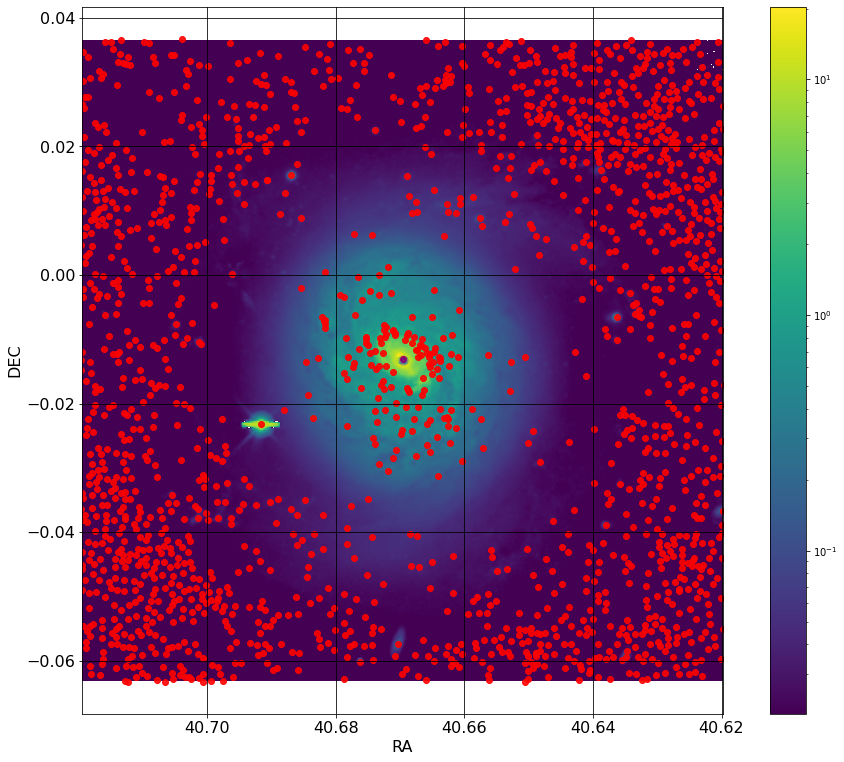

In [31]:
plt.figure(figsize=(17,13))
im=plt.imshow(image, norm=LogNorm(vmax=np.max(image),vmin=np.max(image)/1e3), origin='lower',extent=(ra_max_image,ra_min_image,dec_min_image,dec_max_image))
plt.grid(color='black', ls='solid')
plt.scatter(ra,dec,color='red',alpha=0.9)
plt.scatter([ra_s],[dec_s],color='blue',linewidth=4,alpha=0.3)

plt.xlabel('RA',fontsize=16)
plt.ylabel('DEC',fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar(im)


plt.savefig('figs/image_legacysurvey_%s_log.png'%( suffix ))

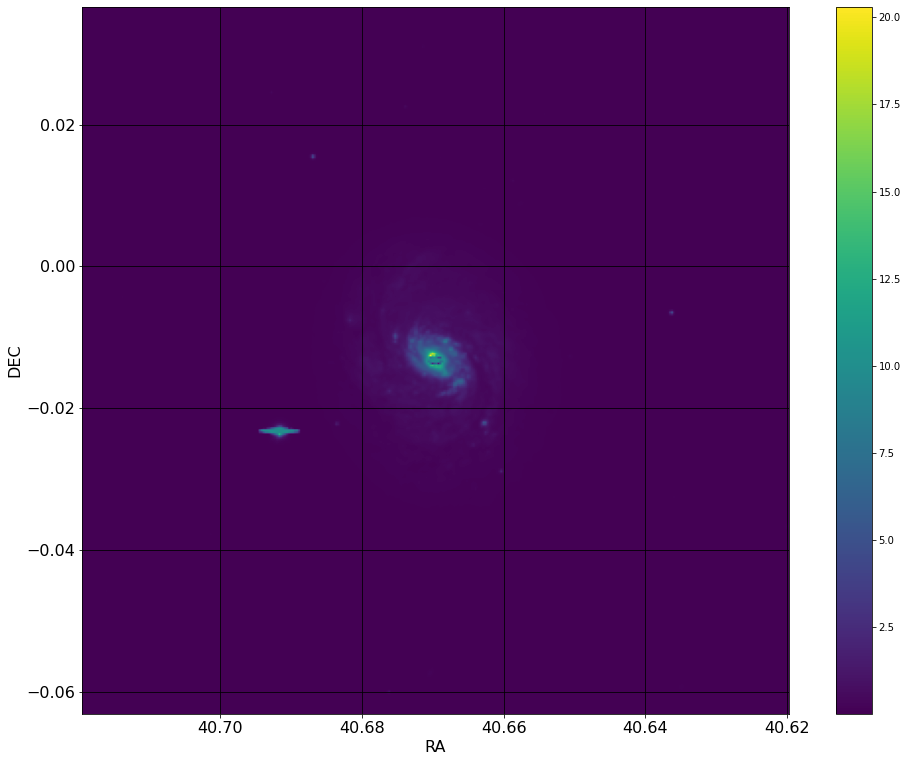

In [32]:
plt.figure(figsize=(17,13))
im=plt.imshow(image, vmax=np.max(image),vmin=np.max(image)/1e3, origin='lower',extent=(ra_max_image,ra_min_image,dec_min_image,dec_max_image))
plt.grid(color='black', ls='solid')
#plt.scatter(ra,dec,color='white',alpha=0.3)
#plt.scatter([ra_degree],[dec_degree],color='blue',linewidth=4,alpha=0.3)

plt.xlabel('RA',fontsize=16)
plt.ylabel('DEC',fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar(im)

plt.savefig('figs/image_legacysuvery_linear.png')

In [33]:
label=['g','r','z','w1','w2','w3','w4']
wavelength=np.array([4770,6231,9134,3.368e4,4.618e4,12.082e4,22.194e4])
wavelength=wavelength*1e-8 # in cm
frequency=3.e10/wavelength # in Hz
energy=2*pi*hbar.to('eV s')/u.eV/u.s*frequency # in eV
factor=1e-23*frequency # conversion of Jy to erg/cm2s
flux=np.zeros(len(label))
err=np.zeros(len(label))
for i in range(len(label)):
    for j in range(len(indexes)):
        if (tap_result['flux_ivar_'+label[i]][indexes[j]]>0):
            flux[i]+=tap_result['flux_'+label[i]][indexes[j]]
            err[i]+=1 / tap_result['flux_ivar_'+label[i]][indexes[j]]

    flux[i]=flux[i]/tap_result['mw_transmission_'+label[i]][index]*nano_maggies_to_Jy*factor[i]
    err[i]=np.sqrt(err[i])/tap_result['mw_transmission_'+label[i]][index]*nano_maggies_to_Jy*factor[i]
    print(energy[i],flux[i],err[i])

data = Table()
data['E'] = energy*u.eV
data['nuFnu'] = flux*u.erg/u.cm**2/u.s
data['nuFnu_err'] = err*u.erg/u.cm**2/u.s
data.write('data/spectrum_legacysurvey_%s.ecsv'%suffix, overwrite=True)
data.info()

2.6010488659898483 3.577386033401825e-09 6.891867799656037e-14
1.9911736624573224 5.1539002648992134e-09 6.463046950134752e-14
1.3583318470299512 5.885992256374001e-09 8.391345448800664e-14
0.36837895162623446 5.252805568437323e-10 9.874500806718558e-14
0.268666156144902 1.7949798087414824e-10 1.512230428245725e-13
0.10268997757632492 2.723142536544446e-09 2.069919112844245e-13
0.0559025100962944 3.793626668689848e-09 4.909453055210824e-13
<Table length=7>
   name    dtype       unit    
--------- ------- -------------
        E float64            eV
    nuFnu float64 erg / (cm2 s)
nuFnu_err float64 erg / (cm2 s)


In [36]:
name_input

'[DW98]  4'

In [34]:
try:
    photometry_ned = Ned.get_table(object_name=name_input,table='photometry')
except:
    print('name not resolved by NED, trying nearest source')
    result_table = Ned.query_region(source, radius=radius_photometry) # <--- change here
    print(result_table)
    ned_name=result_table['Object Name'][0] 
    print(ned_name)
    photometry_ned = Ned.get_table(object_name=ned_name,table='photometry')
E_ned=((photometry_ned['Frequency'])*2*pi*hbar.to('eV s'))
nuFnu_ned=(photometry_ned['Frequency']*photometry_ned['Flux Density']*u.Jy*u.Hz).cgs #erg/cm2/s
#csv_file=open('data/spectrum_ned.csv', mode='w')
#fieldnames = ['E', 'E2_dN_dE', 'E2_dN_dE_error']
#writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#writer.writeheader()
#writer.writerow({'E':'eV', 'E2_dN_dE':'erg/cm2 s', 'E2_dN_dE_error':'erg/cm2 s'})
#for i in range(len(E_ned)):
#    writer.writerow({'E':E_ned[i], 'E2_dN_dE':nuFnu_ned[i], 'E2_dN_dE_error':n})
#csv_file.close()
data = Table()
data['E'] = E_ned*u.eV
data['nuFnu'] = nuFnu_ned*u.erg/u.cm**2/u.s
data.write('data/spectrum_ned_%s.ecsv'%suffix, overwrite=True)
data.info()

name not resolved by NED, trying nearest source
No.       Object Name           RA        DEC     Type  Velocity  ... Notes Photometry Points Positions Redshift Points Diameter Points Associations
                             degrees    degrees          km / s   ...                                                                               
--- ----------------------- ---------- ---------- ---- ---------- ... ----- ----------------- --------- --------------- --------------- ------------
  1  NGC 1068:[GPA2005] NE4   40.66958   -0.01306  IrS         -- ...     0                 0         1               0               0            0
  2  NGC 1068:[GPA2005] NE3   40.66958   -0.01306  IrS         -- ...     0                 0         1               0               0            0
  3 2MASS J02424070-0000480   40.66958   -0.01333  IrS         -- ...     0                 5         3               0               0            0
  4  NGC 1068:[GPA2005] NE1   40.66958   -0.01306  IrS    

RemoteServiceError: The remote service returned the following error message.
ERROR:  No Photometric data points found.

In [ ]:
plt.figure(figsize=(10,7))
plt.errorbar(energy, flux,err,color='red',linewidth=4)
plt.scatter(E_ned,nuFnu_ned)

plt.xlabel('$E$, [eV]',fontsize=16)
plt.ylabel('$E^2dN/dE$, [erg/(cm$^2$s)]',fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("figs/figure_spectrum_legacysurvey_%s.png"%suffix)


In [29]:
#here we prepare output. Images will not be forwarded in production, but now as it is
with open('figs/image_legacysurvey_%s_log.png'%( suffix ), 'rb') as imfd, open('data/catalog_legacysurvey_%s.ecsv'%suffix, 'r') as catfd, open("figs/figure_spectrum_legacysurvey_%s.png"%suffix, 'rb') as specimfd, open('data/spectrum_legacysurvey_%s.ecsv'%suffix, 'r') as specfd, open('data/spectrum_ned_%s.ecsv'%suffix, 'r') as nedspecfd, fits.open('data/image_legacysurvey_%s.fits'%suffix, 'readonly') as imfitsfd:
    image_log = base64.b64encode(imfd.read()).decode()
    catalog = catfd.read()
    spec = specfd.read()
    nedspec = nedspecfd.read()
    spec_im = base64.b64encode(specimfd.read()).decode()
    imfits_head = imfitsfd[0].header.tostring()
    imfits_data = imfitsfd[0].data

In [30]:
image_log = image_log
catalog = catalog
spec_im = spec_im
spec = spec
nedspec = nedspec
imfits_head = imfits_head
imfits_data = imfits_data